In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/team_a/data/xy_data"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['user_info_l.csv',
 'user_info_s.csv',
 'mobile.csv',
 'application.csv',
 'internal_score.csv',
 'pty3rd.csv',
 'inquiry.csv',
 'account.csv',
 'readme.txt',
 'internal data_clean.csv',
 'account_cleaned.csv',
 'pty3rd_cleaned.csv',
 'application_cleaned.csv',
 'mobile_cleaned.csv',
 'inquiry_cleaned.csv',
 'zero_features_drop (2).gsheet',
 'basic_universe.csv',
 'continuous.csv',
 'categorical.csv',
 'zero_features_drop (1).gsheet',
 'application (1).gsheet',
 'application.gsheet',
 'application_oot.csv',
 'inquiry_oot.csv',
 'user_info_l_oot.csv',
 'mobile_oot.csv',
 'internal_score_oot.csv',
 'pty3rd_oot.csv',
 'account_oot.csv',
 'zero_features_drop.csv',
 'zero_features_drop.gsheet',
 'var_description.csv',
 'lgbm_importances-01.png',
 'merge_cleaned.csv',
 'Model_based_Feature_Selection_Lasso.csv',
 'Model_based_Feature_Selection_LGBM.csv',
 'Model_based_Feature_Selection_Lasso_50percent.csv',
 'Model_based_Feature_Selection_Lasso_Basic_Universe.csv',
 'data_bin.csv',
 'data_bi

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# functions
# check missing values
def missing(df):
    k = pd.DataFrame({'total': df.isnull().sum(axis=0), 
                      'percent': df.isnull().sum(axis =0 )/df.shape[0]})
    return k.sort_values('percent', ascending = False)

# drop columns based on the NA%
def drop_columns_missing(df, missing_percent = 1):#missing_percent is in [0,1]
    m = missing(df)
    return df.drop(columns = m.index[m.percent >= missing_percent])

# count unique value of each columns
def unique_values(df):
    return pd.DataFrame({'unique':df.nunique().sort_values()})

def max_mean_mode_min(df):
    mode = df.mode().T
    return pd.DataFrame({'max':df.max(),'min':df.min(),'mean':df.mean(),'mode':mode[0]})

# count special value
def special_values(df,sp_value):
    return pd.DataFrame({'sp'+ str(sp_value): df.apply(lambda x:(x == sp_value)).apply(np.sum)/df.shape[0]})

# 
def check(df):
    m = missing(df)
    m = m.join(unique_values(df))
    m = m.join(special_values(df,0))
    m = m.join(description.description)
    return m

# woe encoding 
def woe_enco(feature):
    import category_encoders as ce
    ec = ce.WOEEncoder()
    df[feature] = df[feature].fillna('NoData')
    X = df[feature]
    y = df['label']
    X_WOE = ec.fit(X, y)
    X_cleaned = ec.transform(X)
    #X_cleaned.round(2)
    df[feature] = X_cleaned
    
# binning
def binning(var):
    df[var]=pd.qcut(df[var],10,duplicates='drop').values.add_categories('NoData')
    df[var]=df[var].fillna("NoData").astype(str)
    df[var].value_counts(dropna=False)
    
 # one-hot   
def onehot(feature):
    import category_encoders as ce
    X = df[feature]
    ec = ce.OneHotEncoder(cols=feature, use_cat_names=True,
                          handle_unknown='indicator').fit(X)
    return ec.fit_transform(X)


def label(feature):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    #le.fit(df[feature])
    return le.transform(df[feature])


In [5]:
account = pd.read_csv('account.csv')
application = pd.read_csv('application.csv')
inquiry = pd.read_csv('inquiry.csv')
user_info_s = pd.read_csv('user_info_s.csv')
user_info_l = pd.read_csv('user_info_l.csv')
pty3rd = pd.read_csv('pty3rd.csv')
internal_score = pd.read_csv('internal_score.csv')
mobile = pd.read_csv('mobile.csv')
description =  pd.read_csv('var_description.csv')
description = description.set_index('Var',drop = True)

dataset = [user_info_l,application,account,inquiry,pty3rd,internal_score,mobile]
train = reduce(lambda left,right: pd.merge(left,right,on=['applied_id']), dataset)
train = train.drop_duplicates()
train.shape

(99072, 382)

In [6]:
account_t = pd.read_csv('account_oot.csv')
application_t = pd.read_csv('application_oot.csv')
inquiry_t = pd.read_csv('inquiry_oot.csv')
user_info_l_t = pd.read_csv('user_info_l_oot.csv')
pty3rd_t = pd.read_csv('pty3rd_oot.csv')
internal_score_t = pd.read_csv('internal_score_oot.csv')
mobile_t = pd.read_csv('mobile_oot.csv')

dataset_t = [user_info_l_t,application_t,account_t,inquiry_t,pty3rd_t,internal_score_t,mobile_t]
test = reduce(lambda left,right: pd.merge(left,right,on=['applied_id']), dataset_t)
test = test.drop_duplicates()
test.shape

(31117, 382)

In [7]:
check(drop_columns_missing(train))

,total,percent,unique,sp0,description
MB6,83084,0.838622,1804,0.000000,totalMemory(andriod)
MB4,83084,0.838622,15765,0.000000,availableMemory(andriod)
MB5,83084,0.838622,15981,0.000000,availableStorage(andriod)
MB7,83084,0.838622,980,0.000000,totalStorage(andriod)
MB10,83084,0.838622,15855,0.000000,DEVICE_INFO
...,...,...,...,...,...
AP7,0,0.000000,1727,0.568001,LOAN_GAP
AP5,0,0.000000,24,0.013606,LOAN_TIME_PHASE1
AP4,0,0.000000,32,0.000000,AGE
AP1,0,0.000000,2,0.000000,CODE_GENDER


In [7]:
pd.DataFrame({'count':train.label.value_counts(),'percent':train.label.value_counts()/len(train)})

,count,percent
0,83839,0.846243
1,15233,0.153757


In [8]:
pd.DataFrame({'count':test.label.value_counts(),'percent':test.label.value_counts()/len(test)})

,count,percent
0,29313,0.942025
1,1804,0.057975


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


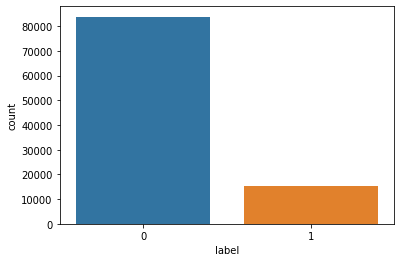

In [9]:
sns.countplot(train.label)

## Drop missing columns and post loan variables

In [8]:
train = drop_columns_missing(train)
test = test[train.columns.values]
print(train.shape, test.shape)

(99072, 234) (31117, 234)


In [9]:
train = train.drop(columns = ['IN18','IN23','IN28','IN33'])
test =  test.drop(columns = ['IN18','IN23','IN28','IN33'])
print(train.shape, test.shape)

(99072, 230) (31117, 230)


## Create notnull features
* To preserve more information, create this kind of features to show where the missing value is.

In [10]:
# create notnull features
train_notnull = train[['applied_id']].copy()
for var in train.columns.values[2:]:
    train_notnull[var+'_notnull'] = train[var].notnull()*1

# create notnull features
test_notnull = test[['applied_id']].copy()
for var in test.columns.values[2:]:
    test_notnull[var+'_notnull'] = test[var].notnull()*1
print(test_notnull.shape,train_notnull.shape)

(31117, 229) (99072, 229)


## Encode categorical variables

In [11]:
categorical = ['AC2', 'AC3', 'AP1', 'AP8', 'IS9', 'MB9','MB12', 'MB13', 'MB14', 'MB15']
check(train[categorical]).join(max_mean_mode_min(train[categorical]))

,total,percent,unique,sp0,description,max,min,mean,mode
AC3,83000,0.837775,9,0.010730,FAMILY_RELATIONSHIP,8,0,5.822175,6
AC2,27932,0.281936,9,0.112948,FAMILY_RELATIONSHIP,8,0,6.122617,8
IS9,37,0.000373,5,0.041939,FLAG_ADDRESS_CHANGE,4,0,2.638189,3
AP1,0,0.000000,2,0.000000,CODE_GENDER,2,1,1.364250,1
AP8,0,0.000000,2,0.747850,FLAG_WEEKEND,1,0,0.252150,0
MB9,0,0.000000,3,0.000000,CODE_OS_TYPE,ios,android,NaN,h5
MB12,0,0.000000,2,0.000000,CODE_NETWORKTYPE,5,1,3.935481,5
MB13,0,0.000000,2,0.963612,FLAG_SPECIFIC_BRAND1,1,0,0.036388,0
MB14,0,0.000000,2,0.889959,FLAG_SPECIFIC_BRAND2,1,0,0.110041,0
MB15,0,0.000000,2,0.700450,FLAG_SPECIFIC_BRAND3,1,0,0.299550,0


* AC2,AC3,IS9,MB9 should be one-hot encoded since we are not sure if they are ordical or not.
* IS9, AC2 and AC3 contain NAs and we have notnull features to mark these NAs, so drop AC2_nan and AC3_nan

In [135]:
#pip install category_encoders

In [12]:
import category_encoders as ce

oe = ce.OneHotEncoder(cols='MB9',handle_unknown='ignore',use_cat_names=True)
train = pd.concat([train, oe.fit_transform(train['MB9'])],axis = 1)
train = train.drop(columns = 'MB9')
test = pd.concat([test, oe.transform(test['MB9']).fillna(0)],axis = 1)
test = test.drop(columns = 'MB9')

In [13]:
oe = ce.OneHotEncoder(cols='IS9',handle_unknown='ignore',use_cat_names=True)
train = pd.concat([train, oe.fit_transform(train['IS9'])],axis = 1)
train = train.drop(columns = ['IS9','IS9_nan'])
test = pd.concat([test, oe.transform(test['IS9'])],axis = 1)
test = test.drop(columns = ['IS9','IS9_nan'])


oe = ce.OneHotEncoder(cols='AC2',handle_unknown='ignore',use_cat_names=True)
train = pd.concat([train, oe.fit_transform(train['AC2'])],axis = 1)
train = train.drop(columns = ['AC2','AC2_nan'])
test = pd.concat([test, oe.transform(test['AC2'])],axis = 1)
test = test.drop(columns = ['AC2','AC2_nan'])

oe = ce.OneHotEncoder(cols='AC3',handle_unknown='ignore',use_cat_names=True)
train = pd.concat([train, oe.fit_transform(train['AC3'])],axis = 1)
train = train.drop(columns = ['AC3','AC3_nan'])
test = pd.concat([test, oe.transform(test['AC3'])],axis = 1)
test = test.drop(columns = ['AC3','AC3_nan'])

* MB12, network type, only contains value 1 - wifi and 5 - other.
* AP1, code gender, only contains value 1 - male and 2 - female.
* create one dummy variable.

In [14]:
train['AP1_male'] = (train['AP1'] == 1)*1
train = train.drop(columns = 'AP1')
test['AP1_male'] = (test['AP1'] == 1)*1
test = test.drop(columns = 'AP1')

train['MB12_wifi'] = (train['MB12'] == 1)*1
train = train.drop(columns = 'MB12')
test['MB12_wifi'] = (test['MB12'] == 1)*1
test = test.drop(columns = 'MB12')

In [15]:
print(train.shape,test.shape)

(99072, 252) (31117, 252)


## Imputation
* Imputate NAs with 0, mean, median, mode. Try the 4 imputation methods and find mode may be more practical.

In [16]:
# impute with 0 
train_0 = train.fillna(0)
test_0 = test.fillna(0)

# impute with mean
from sklearn.impute import SimpleImputer
imputer1 = SimpleImputer(np.nan, "mean")
train_mean = pd.DataFrame(imputer1.fit_transform(train), columns = train.columns)
test_mean = pd.DataFrame(imputer1.transform(test), columns = test.columns)

# impute with median
imputer2 = SimpleImputer(np.nan, "median")
train_median = pd.DataFrame(imputer2.fit_transform(train), columns = train.columns)
test_median = pd.DataFrame(imputer2.transform(test), columns = test.columns)

# impute with mode
imputer3 = SimpleImputer(np.nan, "most_frequent")
train_mode = pd.DataFrame(imputer3.fit_transform(train), columns = train.columns)
test_mode = pd.DataFrame(imputer3.transform(test), columns = test.columns)

## Create binned features
* Discretization of continuous variables may improve model performance. Outliers are resolved through bins.
* And the bins of continuous variables are ordinal, so I directly use the labels returned by the qcut function to represent each bin and create bin_cate features to store the variables in category type.

In [17]:
train_mode.columns.values

array(['applied_id', 'label', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7',
       'AP8', 'AC1', 'AC4', 'AC5', 'AC6', 'AC7', 'AC8', 'AC9', 'AC10',
       'AC11', 'AC12', 'AC13', 'AC14', 'AC15', 'AC16', 'AC17', 'AC18',
       'AC19', 'AC20', 'IN1', 'IN2', 'IN3', 'IN4', 'IN5', 'IN6', 'IN7',
       'IN8', 'IN9', 'IN10', 'IN11', 'IN12', 'IN13', 'IN14', 'IN15',
       'IN16', 'IN17', 'IN19', 'IN20', 'IN21', 'IN22', 'IN24', 'IN25',
       'IN26', 'IN27', 'IN29', 'IN30', 'IN31', 'IN32', 'IN34', 'IN35',
       'IN36', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18',
       'P19', 'P20', 'P21', 'P22', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P49', 'P50', 'P51',
       'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P61', 'P62',
       'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P73',
       'P74', 

In [18]:
categorical = ['AP8', 'MB13', 'MB14', 'MB15',
               'MB9_ios', 'MB9_android', 'MB9_h5', 'IS9_3.0', 'IS9_2.0',
               'IS9_1.0', 'IS9_4.0', 'IS9_0.0', 'AC2_8.0', 'AC2_0.0', 'AC2_2.0',
               'AC2_4.0', 'AC2_6.0', 'AC2_7.0', 'AC2_3.0', 'AC2_1.0', 'AC2_5.0',
               'AC3_8.0', 'AC3_6.0', 'AC3_7.0', 'AC3_5.0', 'AC3_1.0', 'AC3_0.0',
              'AC3_4.0', 'AC3_2.0', 'AC3_3.0', 'AP1_male', 'MB12_wifi']


In [19]:
train_bin = train_mode[['applied_id']].copy()
test_bin = test_mode[['applied_id']].copy()
train_bin_cate = train_mode[['applied_id']].copy()
test_bin_cate = test_mode[['applied_id']].copy()
test_tmp = test_mode.copy()
for var in train_mode.drop(columns = categorical).columns.values[2:]:
    train_bin[var+'_bin'],bins = pd.qcut(train_mode[var],10,duplicates='drop', labels=False,retbins=True)
    train_bin_cate[var+'_bin_cate'],bins = pd.qcut(train_mode[var],10,duplicates='drop',retbins=True)

    # out of bounds are grouped into the smallest and the larget bins
    test_tmp[var][test_tmp[var]< min(train_mode[var])] = min(train_mode[var]) 
    test_tmp[var][test_tmp[var]> max(train_mode[var])] = max(train_mode[var])

    test_bin[var+'_bin'] = pd.cut(test_tmp[var], bins=bins, labels=False, include_lowest=True)
    test_bin_cate[var+'_bin_cate'] = pd.cut(test_mode[var], bins=bins, include_lowest=True)
    

In [20]:
print(train_bin.shape,test_bin.shape)

(99072, 219) (31117, 219)


## Interaction Features
### Interaction between variables in Application
I built several interaction features using variables in each specific dataset and applied a simple decision tree model to check if these features could improve the model performance. So far, model with the interaction features made up of variables in Application shows an explicit improvement. So I put these features in.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
pl=PolynomialFeatures(degree=2, interaction_only=True,  include_bias = False)
# application
ap = drop_columns_missing(application.drop_duplicates()).drop(columns = ['AP1', 'AP8']).columns[1:]
 
ap_in_train = pd.DataFrame(pl.fit_transform(train_mode[ap]), columns = pl.get_feature_names(ap))
ap_in_train = ap_in_train.drop(columns = ap)
ap_in_train['applied_id'] = train_mode['applied_id']

ap_in_test = pd.DataFrame(pl.fit_transform(test_mode[ap]), columns = pl.get_feature_names(ap))
ap_in_test = ap_in_test.drop(columns = ap)
ap_in_test['applied_id'] = test_mode['applied_id']

print(ap_in_train.shape,ap_in_test.shape)

(99072, 16) (31117, 16)


## Merge cleaned dataset

In [22]:
df_train = pd.merge(train_mode,train_bin, on = 'applied_id',how = 'left')
df_train = pd.merge(df_train, train_notnull, on = 'applied_id',how = 'left')
df_train = pd.merge(df_train, ap_in_train, on = 'applied_id',how = 'left')
df_train.shape

(99072, 713)

In [23]:
df_test = pd.merge(test_mode,test_bin, on = 'applied_id',how = 'left')
df_test = pd.merge(df_test, test_notnull, on = 'applied_id',how = 'left')
df_test = pd.merge(df_test, ap_in_test, on = 'applied_id',how = 'left')
df_test.shape

(31117, 713)

## Drop identical columns and columns with one unique value.

In [24]:
tmp = pd.concat([df_train,df_test],axis = 0)
# remove duplicated columns
c = tmp.columns
remove = []
for i in range(len(c)-1):
    v = tmp[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,tmp[c[j]].values):
            remove.append(c[j])
            #print(' Column %s is identical to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))

tmp.drop(remove, axis=1, inplace=True)
print('\n Number of columns after cleaning: %d' % len(tmp.columns))
train_len = len(df_train)
train_clean = tmp[: train_len ]
test_clean = tmp[train_len : ]
print(train_clean.shape,test_clean.shape)


 Number of columns after cleaning: 352
(99072, 352) (31117, 352)


In [25]:
col = unique_values(train_clean)[unique_values(train_clean).unique<2].index.values 
train_clean = train_clean.drop(columns = col)
test_clean = test_clean.drop(columns = col)

print('\n Number of columns after cleaning: %d' % train_clean.shape[1])
print(train_clean.shape,test_clean.shape)


 Number of columns after cleaning: 345
(99072, 345) (31117, 345)


In [26]:
train_clean.set_index('applied_id',drop = True).to_csv('cleaned_v5_xy.csv')
test_clean.set_index('applied_id',drop = True).to_csv('cleaned_v5_oot.csv')

In [27]:
check(test_clean)

,total,percent,unique,sp0,description
applied_id,0,0.0,31117,0.000000,NaN
AC2_0.0,0,0.0,2,0.971720,NaN
AC3_8.0,0,0.0,2,0.984960,NaN
AC2_5.0,0,0.0,2,0.997301,NaN
AC2_1.0,0,0.0,2,0.999004,NaN
...,...,...,...,...,...
P68,0,0.0,85,0.985956,THIRD_PARTY_VARIABLE
P67,0,0.0,7,0.998618,THIRD_PARTY_VARIABLE
P66,0,0.0,29,0.998618,THIRD_PARTY_VARIABLE
P65,0,0.0,10,0.985121,THIRD_PARTY_VARIABLE


In [28]:
train_clean.columns.values 

array(['applied_id', 'label', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7',
       'AP8', 'AC1', 'AC4', 'AC5', 'AC6', 'AC7', 'AC8', 'AC9', 'AC10',
       'AC11', 'AC12', 'AC13', 'AC14', 'AC15', 'AC16', 'AC17', 'AC18',
       'IN1', 'IN2', 'IN3', 'IN4', 'IN5', 'IN6', 'IN7', 'IN8', 'IN9',
       'IN10', 'IN11', 'IN12', 'IN13', 'IN14', 'IN15', 'IN16', 'IN17',
       'IN21', 'IN22', 'IN24', 'IN25', 'IN26', 'IN27', 'IN29', 'IN30',
       'IN31', 'IN32', 'IN34', 'IN35', 'IN36', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
       'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34',
       'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45',
       'P46', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56',
       'P57', 'P58', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67',
       'P68', 'P69', 'P70', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78',
       'P79

In [30]:
imputed_features = ['AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7',
       'AC1', 'AC4', 'AC5', 'AC6', 'AC7', 'AC8', 'AC9', 'AC10',
       'AC11', 'AC12', 'AC13', 'AC14', 'AC15', 'AC16', 'AC17', 'AC18',
       'IN1', 'IN2', 'IN3', 'IN4', 'IN5', 'IN6', 'IN7', 'IN8', 'IN9',
       'IN10', 'IN11', 'IN12', 'IN13', 'IN14', 'IN15', 'IN16', 'IN17',
       'IN21', 'IN22', 'IN24', 'IN25', 'IN26', 'IN27', 'IN29', 'IN30',
       'IN31', 'IN32', 'IN34', 'IN35', 'IN36', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
       'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34',
       'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45',
       'P46', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56',
       'P57', 'P58', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67',
       'P68', 'P69', 'P70', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78',
       'P79', 'P80', 'P81', 'P82', 'P85', 'P86', 'P87', 'P88', 'P89',
       'P90', 'P91', 'P92', 'P93', 'P94', 'P97', 'P98', 'P99', 'P100',
       'P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P109', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P129', 'P130', 'P133', 'P134', 'P135', 'P136', 'P137', 'P138',
       'P139', 'P140', 'P141', 'P142', 'P145', 'P146', 'P147', 'P148',
       'P149', 'P150', 'P151', 'P152', 'P153', 'P154', 'P157', 'P158',
       'P159', 'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166',
       'IS1', 'IS2', 'IS3', 'IS4', 'IS5', 'IS6', 'IS7', 'IS8', 'IS10',
       'IS11', 'MB1', 'MB2', 'MB4', 'MB5', 'MB6', 'MB7', 'MB8', 'MB10',
       'MB11']

cate_features = ['AP8', 'MB13', 'MB14', 'MB15','MB9_android', 'MB9_h5', 'IS9_3.0',
       'IS9_2.0', 'IS9_1.0', 'IS9_4.0', 'IS9_0.0', 'AC2_8.0', 'AC2_0.0',
       'AC2_2.0', 'AC2_4.0', 'AC2_6.0', 'AC2_7.0', 'AC2_3.0', 'AC2_1.0',
       'AC2_5.0', 'AC3_8.0', 'AC3_6.0', 'AC3_7.0', 'AC3_5.0', 'AC3_1.0',
       'AC3_0.0', 'AC3_4.0', 'AC3_2.0', 'AC3_3.0', 'AP1_male','MB12_wifi']

bin_features = ['AP2_bin', 'AP3_bin', 'AP4_bin', 'AP5_bin', 'AP6_bin',
       'AP7_bin', 'AC1_bin', 'AC4_bin', 'AC5_bin', 'AC6_bin', 'AC7_bin',
       'AC11_bin', 'AC12_bin', 'AC13_bin', 'AC14_bin', 'IN1_bin',
       'IN2_bin', 'IN3_bin', 'IN5_bin', 'IN6_bin', 'IN7_bin', 'IN9_bin',
       'IN10_bin', 'IN11_bin', 'IN13_bin', 'IN14_bin', 'IN15_bin',
       'IN17_bin', 'IN21_bin', 'IN22_bin', 'IN26_bin', 'IN27_bin',
       'IN31_bin', 'IN32_bin', 'IN36_bin', 'P4_bin', 'P5_bin', 'P8_bin',
       'P9_bin', 'P10_bin', 'P12_bin', 'P13_bin', 'P16_bin', 'P17_bin',
       'P20_bin', 'P21_bin', 'P22_bin', 'IS1_bin', 'IS2_bin', 'IS3_bin',
       'IS4_bin', 'IS5_bin', 'IS6_bin', 'IS7_bin', 'IS8_bin', 'IS10_bin',
       'IS11_bin', 'MB1_bin', 'MB2_bin', 'MB4_bin', 'MB5_bin', 'MB6_bin',
       'MB7_bin', 'MB8_bin', 'MB10_bin', 'MB11_bin']

notnull_features = ['AP2_notnull',
       'AC1_notnull', 'AC2_notnull', 'AC3_notnull', 'AC11_notnull',
       'AC12_notnull', 'IN1_notnull', 'IN17_notnull', 'P1_notnull',
       'IS1_notnull', 'IS3_notnull', 'IS8_notnull', 'IS9_notnull',
       'IS10_notnull', 'MB1_notnull', 'MB4_notnull', 'MB8_notnull',
       'MB10_notnull']

interaction_features = ['AP2 AP3', 'AP2 AP4', 'AP2 AP5', 'AP2 AP6',
       'AP2 AP7', 'AP3 AP4', 'AP3 AP5', 'AP3 AP6', 'AP3 AP7', 'AP4 AP5',
       'AP4 AP6', 'AP4 AP7', 'AP5 AP6', 'AP5 AP7', 'AP6 AP7']

print('Number of Imputed Features:', len(imputed_features))
print('Number of Category Features:', len(cate_features))
print('Number of Binned Features:', len(bin_features))
print('Number of Notnull Features:', len(notnull_features))
print('Number of Interaction Features:', len(interaction_features))

Number of Imputed Features: 213
Number of Category Features: 31
Number of Binned Features: 66
Number of Notnull Features: 18
Number of Interaction Features: 15


## Feature Selection using Lasso

In [29]:
merge_cleaned = pd.read_csv("cleaned_v5_xy.csv")
# Stratefied sampling 50% data for feature selection -> Prevent overfitting
from sklearn.model_selection import train_test_split
y = merge_cleaned['label']
X = merge_cleaned.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state=2020)
stratified_data = X_test
stratified_data

,applied_id,AP2,AP3,AP4,AP5,AP6,AP7,AP8,AC1,AC4,AC5,AC6,AC7,AC8,AC9,AC10,AC11,AC12,AC13,AC14,AC15,AC16,AC17,AC18,IN1,IN2,IN3,IN4,IN5,IN6,IN7,IN8,IN9,IN10,IN11,IN12,IN13,IN14,IN15,IN16,...,MB4_bin,MB5_bin,MB6_bin,MB7_bin,MB8_bin,MB10_bin,MB11_bin,AP2_notnull,AC1_notnull,AC2_notnull,AC3_notnull,AC11_notnull,AC12_notnull,IN1_notnull,IN17_notnull,P1_notnull,IS1_notnull,IS3_notnull,IS8_notnull,IS9_notnull,IS10_notnull,MB1_notnull,MB4_notnull,MB8_notnull,MB10_notnull,AP2 AP3,AP2 AP4,AP2 AP5,AP2 AP6,AP2 AP7,AP3 AP4,AP3 AP5,AP3 AP6,AP3 AP7,AP4 AP5,AP4 AP6,AP4 AP7,AP5 AP6,AP5 AP7,AP6 AP7
52134,35035735.0,0.010833,0.041944,27.0,10.0,11.0,59.0,0.0,1.0,20000.0,20000.0,0.0,1753.0,0.0,0.0,0.0,1.0,20000.0,1.0,18405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0,0,1,1,2,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0.000454,0.292491,0.108330,0.119163,0.639147,1.132488,0.419440,0.461384,2.474696,270.0,297.0,1593.0,110.0,590.0,649.0
69499,38294215.0,0.010833,0.041944,50.0,17.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0,0,1,1,2,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0.000454,0.541650,0.184161,0.119163,0.000000,2.097200,0.713048,0.461384,0.000000,850.0,550.0,0.0,187.0,0.0,0.0
37214,39146878.0,0.047778,542.868611,31.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,32000.0,3.0,14033.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,1.0,4.0,0.0,3.0,2.0,5.0,0.0,4.0,4.0,5.0,0.0,...,0,0,1,1,4,0,2,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,1,0,25.937176,1.481118,0.334446,0.334446,0.000000,16828.926941,3800.080277,3800.080277,0.000000,217.0,217.0,0.0,49.0,0.0,0.0
34353,36223159.0,0.010833,0.041944,31.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5000.0,1.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0,0,1,1,2,0,0,0,1,0,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0.000454,0.335823,0.097497,0.119163,0.000000,1.300264,0.377496,0.461384,0.000000,279.0,341.0,0.0,99.0,0.0,0.0
58670,34836139.0,0.010833,0.041944,35.0,14.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2220.0,8.0,1509.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,...,0,0,1,1,2,0,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0.000454,0.379155,0.151662,0.119163,0.000000,1.468040,0.587216,0.461384,0.000000,490.0,385.0,0.0,154.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28458,36739303.0,12.700000,0.052222,27.0,11.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0,0,1,1,3,0,2,1,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0.663219,342.900000,139.700000,292.100000,0.000000,1.409994,0.574442,1.201106,0.000000,297.0,621.0,0.0,253.0,0.0,0.0
7622,34484087.0,0.010833,0.041944,24.0,10.0,11.0,816.0,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,3.0,0.0,...,0,0,1,1,4,0,3,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0.000454,0.259992,0.108330,0.119163,8.839728,1.006656,0.419440,0.461384,34.226304,240.0,264.0,19584.0,110.0,8160.0,8976.0
16921,36940225.0,0.010833,0.041944,27.0,22.0,11.0,924.0,0.0,6.0,4400.0,9899.0,7213.0,1225.0,0.0,0.0,0.0,15.0,133300.0,1.0,2800.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,...,0,0,1,1,2,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0.000454,0.292491,0.238326,0.119163,10.009692,1.132488,0.922768,0.461384,38.756256,594.0,297.0,24948.0,242.0,20328.0,10164.0
73298,37698297.0,0.035000,761.191389,31.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,18670.0,3.0,10348.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,0.0,2.0,4.0,3.0,0.0,14

In [31]:
X_id = stratified_data.drop(columns=['applied_id'])
print(X_id.shape)
y = y_test
print(y.shape)

(49536, 343)
(49536,)


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

Xtrain, Xtest, ytrain, ytest = train_test_split(X_id, y, random_state=202010)

scaler = StandardScaler()
scaler.fit(Xtrain.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
sel_ = SelectFromModel(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))
sel_.fit(scaler.transform(Xtrain.fillna(0)), ytrain)

SelectFromModel(estimator=LogisticRegression(C=0.01, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [34]:
selected_feats = Xtrain.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]
print('total features: {}'.format((Xtrain.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 343
selected features: 68
features with coefficients shrank to zero: 275


In [35]:
selected_feats = Xtrain.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]
print(selected_feats)
# selected features: 68 (having not zero coefficients)

Index(['AC7', 'AC11', 'AC12', 'AC14', 'IN1', 'IN2', 'IN6', 'IN13', 'IN15',
       'IN16', 'IN27', 'IN29', 'IN30', 'IN36', 'P11', 'P13', 'P42', 'P46',
       'P49', 'P50', 'P76', 'P79', 'P85', 'P92', 'P121', 'P123', 'P125',
       'P157', 'P165', 'IS2', 'IS8', 'IS11', 'MB2', 'MB13', 'MB9_h5',
       'IS9_1.0', 'IS9_4.0', 'AC2_0.0', 'AC2_2.0', 'AC2_1.0', 'AC2_5.0',
       'AC3_8.0', 'AC3_1.0', 'AC3_0.0', 'AP1_male', 'MB12_wifi', 'AP4_bin',
       'AC14_bin', 'IN1_bin', 'IN3_bin', 'IN5_bin', 'IN9_bin', 'IN13_bin',
       'IN14_bin', 'IN17_bin', 'IN32_bin', 'P4_bin', 'P8_bin', 'IS1_bin',
       'IS3_bin', 'MB8_bin', 'AC2_notnull', 'AC11_notnull', 'AC12_notnull',
       'IN17_notnull', 'P1_notnull', 'MB8_notnull', 'AP5 AP7'],
      dtype='object')


In [36]:
removed_feats = Xtrain.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
print(removed_feats)

Index(['AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AC1', 'AC4', 'AC5',
       ...
       'AP2 AP7', 'AP3 AP4', 'AP3 AP5', 'AP3 AP6', 'AP3 AP7', 'AP4 AP5',
       'AP4 AP6', 'AP4 AP7', 'AP5 AP6', 'AP6 AP7'],
      dtype='object', length=275)


In [37]:
df_selected = merge_cleaned.drop(removed_feats, axis=1)

v5_oot = pd.read_csv("cleaned_v5_oot.csv")
v5_oot_selected = v5_oot[df_selected.columns.values]


# Save result of Lasso feature selection 
df_selected.to_csv('Lasso_Feature_Selection_cleaned_v5_xy.csv', index=False)
v5_oot_selected.to_csv('Lasso_Feature_Selection_cleaned_v5_oot.csv', index=False)

In [38]:
print('Result:')
print('total features: {}'.format((Xtrain.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

Result:
total features: 343
selected features: 68
features with coefficients shrank to zero: 275


## Feature Description

In [39]:
selected_feats

Index(['AC7', 'AC11', 'AC12', 'AC14', 'IN1', 'IN2', 'IN6', 'IN13', 'IN15',
       'IN16', 'IN27', 'IN29', 'IN30', 'IN36', 'P11', 'P13', 'P42', 'P46',
       'P49', 'P50', 'P76', 'P79', 'P85', 'P92', 'P121', 'P123', 'P125',
       'P157', 'P165', 'IS2', 'IS8', 'IS11', 'MB2', 'MB13', 'MB9_h5',
       'IS9_1.0', 'IS9_4.0', 'AC2_0.0', 'AC2_2.0', 'AC2_1.0', 'AC2_5.0',
       'AC3_8.0', 'AC3_1.0', 'AC3_0.0', 'AP1_male', 'MB12_wifi', 'AP4_bin',
       'AC14_bin', 'IN1_bin', 'IN3_bin', 'IN5_bin', 'IN9_bin', 'IN13_bin',
       'IN14_bin', 'IN17_bin', 'IN32_bin', 'P4_bin', 'P8_bin', 'IS1_bin',
       'IS3_bin', 'MB8_bin', 'AC2_notnull', 'AC11_notnull', 'AC12_notnull',
       'IN17_notnull', 'P1_notnull', 'MB8_notnull', 'AP5 AP7'],
      dtype='object')

In [40]:
imputed_features1 = ['AC7', 'AC11', 'AC12', 'AC14', 'IN1', 'IN2', 'IN6', 'IN13', 'IN15',
       'IN16', 'IN27', 'IN29', 'IN30', 'IN36', 'P11', 'P13', 'P42', 'P46',
       'P49', 'P50', 'P76', 'P79', 'P85', 'P92', 'P121', 'P123', 'P125',
       'P157', 'P165', 'IS2', 'IS8', 'IS11', 'MB2']

cate_features1 = ['MB13', 'MB9_h5',
       'IS9_1.0', 'IS9_4.0', 'AC2_0.0', 'AC2_2.0', 'AC2_1.0', 'AC2_5.0',
       'AC3_8.0', 'AC3_1.0', 'AC3_0.0', 'AP1_male', 'MB12_wifi']

bin_features1 = ['AP4_bin',
       'AC14_bin', 'IN1_bin', 'IN3_bin', 'IN5_bin', 'IN9_bin', 'IN13_bin',
       'IN14_bin', 'IN17_bin', 'IN32_bin', 'P4_bin', 'P8_bin', 'IS1_bin',
       'IS3_bin', 'MB8_bin']

notnull_features1 = ['AC2_notnull', 'AC11_notnull', 'AC12_notnull',
       'IN17_notnull', 'P1_notnull', 'MB8_notnull']

interaction_features1 = ['AP5 AP7']

print('Number of Imputed Features:', len(imputed_features1))
print('Number of Category Features:', len(cate_features1))
print('Number of Binned Features:', len(bin_features1))
print('Number of Notnull Features:', len(notnull_features1))
print('Number of Interaction Features:', len(interaction_features1))

Number of Imputed Features: 33
Number of Category Features: 13
Number of Binned Features: 15
Number of Notnull Features: 6
Number of Interaction Features: 1


In [43]:
#pd.set_option('display.max_rows',70)
#pd.set_option('display.max_columns',70)
#train_clean[selected_feats].corr()[train_clean[selected_feats].corr()>0.8]

In [44]:
df_features = train_clean[selected_feats]
check(df_features)

,total,percent,unique,sp0,description
AC7,0,0.0,8881,0.660762,REPAYMENT_PER_MONTH
AC3_0.0,0,0.0,2,0.989270,NaN
IN3_bin,0,0.0,3,0.896853,NaN
IN1_bin,0,0.0,4,0.669352,NaN
AC14_bin,0,0.0,6,0.500020,NaN
AP4_bin,0,0.0,10,0.149689,NaN
MB12_wifi,0,0.0,2,0.733870,NaN
AP1_male,0,0.0,2,0.364250,NaN
AC3_1.0,0,0.0,2,0.992763,NaN
AC11,0,0.0,152,0.305778,LOAN_CUT_VARIABLE


In [47]:
for var in bin_features1:
     print('Name:',var, ':')
     mm = pd.DataFrame(pd.DataFrame({'code':train_bin[var],'cate':train_bin_cate[var+'_cate']}).value_counts())
     print(mm.sort_values('code'))
     print()

Name: AP4_bin :
                         0
code cate                 
0    (19.999, 23.0]  14830
1    (23.0, 24.0]     7414
2    (24.0, 26.0]    14123
3    (26.0, 27.0]     6427
4    (27.0, 29.0]    13420
5    (29.0, 30.0]     5777
6    (30.0, 32.0]     9875
7    (32.0, 35.0]     9313
8    (35.0, 39.0]     8693
9    (39.0, 51.0]     9200

Name: AC14_bin :
                               0
code cate                       
0    (-0.001, 2015.0]      49538
1    (2015.0, 7104.2]       9905
2    (7104.2, 15438.7]      9907
3    (15438.7, 30149.6]     9907
4    (30149.6, 65639.8]     9907
5    (65639.8, 3573509.0]   9908

Name: IN1_bin :
                        0
code cate                
0    (-0.001, 1.0]  66314
1    (1.0, 2.0]     17692
2    (2.0, 3.0]      7773
3    (3.0, 17.0]     7293

Name: IN3_bin :
                        0
code cate                
0    (-0.001, 1.0]  88853
1    (1.0, 2.0]      7359
2    (2.0, 9.0]      2860

Name: IN5_bin :
                        0
code cate      